### This code runs with:

conda version : 4.8.3
<br>
conda-build version : 3.18.11
<br>
python version : 3.7.6.final.0
<br>
numpy :                      1.18.1
<br>
matplotlib :                 3.1.3
<br>
pandas :                     1.0.3
<br>
scikit-learn :               0.22.1
<br>
scipy :                      1.4.1
<br>
pydub :                      0.23.1
<br>
python-speech-features :     0.6
<br>
pyaudio :                    0.2.11

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import sys
import random
import pylab as pl
from collections import Counter
from python_speech_features import mfcc
import pyaudio
import wave

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

from scipy.io.wavfile import write
from scipy.io import wavfile

from pydub import AudioSegment
from pydub.playback import play

%matplotlib inline

In [29]:
# Pyaudio functions

# Plays an audio clip given the clip index
def read_wav_file(filename):
    spf = wave.open(filename, 'rb')
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    
    samplerate = spf.getframerate()
    samplewidth = spf.getsampwidth()
    num_channels = spf.getnchannels()
    
    p = pyaudio.PyAudio()
    stream = p.open(format =
                p.get_format_from_width(samplewidth),
                channels = num_channels,
                rate = samplerate,
                output = True)
    
    return signal, stream, samplerate, samplewidth, num_channels

# TODO: Currently bugged
def play_signal(signal):
    sig = signal
    
    stream.write(signal)
    
def save_signal(filename, signal, samplerate):
    assert('.' not in filename)
    obj = wave.open(filename + '.wav','w')
    obj.setnchannels(num_channels)
    obj.setsampwidth(samplewidth)
    obj.setframerate(samplerate)
    
    sig = signal
    
    obj.writeframesraw(signal)

    obj.close()
    
def play_clip(clip_index):
    play_signal(shorter_clips[clip_index])
    
def save_clip(filename, clip_index):
    save_signal(filename, shorter_clips[clip_index], samplerate)
    
# old sounddevice functions - Now using PyAudio instead
"""
# Plays an audio clip given the clip index
def play_clip(clip_index):
    samples = shorter_clips[clip_index]
    sd.play(samples, samplerate)
    
# Saves clip as a wav file
def save_clip(filename, wav_array):
    assert('.' not in filename)
    write(filename + '.wav', samplerate, wav_array)
""";

In [30]:
# Returns all clip indexes within a cluster
def get_clip_indexes(cluster_label, clusters):
    clips_i = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_label:
            clips_i.append(i)
    return clips_i

# Plays a random clip in a given cluster
def play_random_clip_in_cluster(index, clusters, option='cluster'):
    assert(option == 'cluster' or option == 'clip')
    if option == 'clip':
        index = find_cluster(index, clusters) # Get cluster index
    
    clips = get_clip_indexes(index, clusters)
    clip_i = clips[random.randint(0, len(clips) - 1)]
    print('Playing clip index %d ' % clip_i)
    play_clip(clip_i)
        
# Returns the cluster label that a clip belongs to
def find_cluster(clip_index, clusters):
    return clusters[clip_index]

# Flattens a given list
def list_flatten(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list
    
# Saves all clips to a directory
def save_clips_to_dir(shorter_clips, dirname):
    for i, clip in enumerate(shorter_clips):
        save_clip(dirname + '/%d' % i, clip) 

## Load Audio Data

In [31]:
### Change this to load in different audio datasets
dir_path = './GRABADOR-SDZG-AM-15/'




stream = None
samplerate = None
samplewidth = None
num_channels = None
wav_data = []
for file in glob.glob(dir_path + '*.wav'):
    try: 
        
        data, stream, samplerate, samplewidth, num_channels = read_wav_file(file)
        
        #rate, data = wavfile.read(file)
        #data = data.astype(int)
        #samplerate = rate
        
        if wav_data == []:
            wav_data = data
        else:
            wav_data = np.concatenate((wav_data, data))
        print(file)
    except Exception as e:
        print('(failed) ' + file)
        print('\t' + str(e))
        pass

C:\Users\Erika\anaconda3\envs\Python3-7\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  import sys
C:\Users\Erika\anaconda3\envs\Python3-7\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


./GRABADOR-SDZG-AM-15\20190611_202000.WAV


C:\Users\Erika\anaconda3\envs\Python3-7\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


./GRABADOR-SDZG-AM-15\20190611_203000.WAV
./GRABADOR-SDZG-AM-15\20190611_204000.WAV
./GRABADOR-SDZG-AM-15\20190611_205000.WAV
./GRABADOR-SDZG-AM-15\20190611_210000.WAV
./GRABADOR-SDZG-AM-15\20190611_211000.WAV
./GRABADOR-SDZG-AM-15\20190611_212000.WAV
./GRABADOR-SDZG-AM-15\20190611_213000.WAV
./GRABADOR-SDZG-AM-15\20190611_214000.WAV
./GRABADOR-SDZG-AM-15\20190611_215000.WAV
./GRABADOR-SDZG-AM-15\20190611_220000.WAV
./GRABADOR-SDZG-AM-15\20190611_221000.WAV
./GRABADOR-SDZG-AM-15\20190611_222000.WAV


In [33]:
print('length = %.1fs' % (wav_data.shape[0] / samplerate / 2))

length = 390.0s


## Split Audio Data

In [37]:
# Get n-second clips
def split_into_n_seconds(wav_data, samplerate, n=10):
    assert(n > 0)
    
    length_in_seconds = len(wav_data) / samplerate
    length_in_minutes = length_in_seconds / 60
    length_in_minutes = int(length_in_minutes)
    shorter_len = int(length_in_minutes / (1/(60/n)))
    
    second_clips = None
    
    try: 
        second_clips = np.split(wav_data, shorter_len)
        
    except:
        cut_wav_data = wav_data[:-((len(wav_data)) % shorter_len)]
        second_clips = np.split(cut_wav_data, shorter_len)

    print('%d %d-second clips' % (len(second_clips), n))
    return np.array(second_clips)

In [133]:
shorter_clips = split_into_n_seconds(wav_data, samplerate, 10)

78 10-second clips


In [39]:
# Make sure audio is working
play_clip(1)

# Make sure clips can be saved as .wav files
save_clip('test', 1)

# Spectrograms

In [88]:
def plot_spectrogram(samplerate, shorter_clips, clip_index, separate_channels=False):
    clip = shorter_clips[clip_index].reshape((int(len(shorter_clips[clip_index]) / 2), 2))
    
    left_channel = clip[:, 0]
    right_channel = clip[:, 1]
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Clip #%d (Left Channel)' % clip_index)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Clip #%d (Right Channel)' % clip_index)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Clip #%d' % clip_index)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()
    
# Currently bugged
"""
def plot_spectrogram_of_cluster(samplerate, shorter_clips, cluster_i, clusters, separate_channels=False):
    clip_indexes = get_clip_indexes(cluster_i, clusters)
    
    clips = shorter_clips[clip_indexes[0]].reshape((int(len(shorter_clips[clip_indexes[0]]) / 2), 2))
    
    left_channel = clips[:, 0]
    right_channel = clips[:, 1]
    
    for i in range(1, len(clip_indexes)):
        left_channel = np.append(left_channel, shorter_clips[clip_indexes[i]][:, 0])
        right_channel = np.append(right_channel, shorter_clips[clip_indexes[i]][:, 1])
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Cluster #%d (Left Channel)' % cluster_i)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Cluster #%d (Right Channel)' % cluster_i)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Cluster #%d' % cluster_i)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()
""";

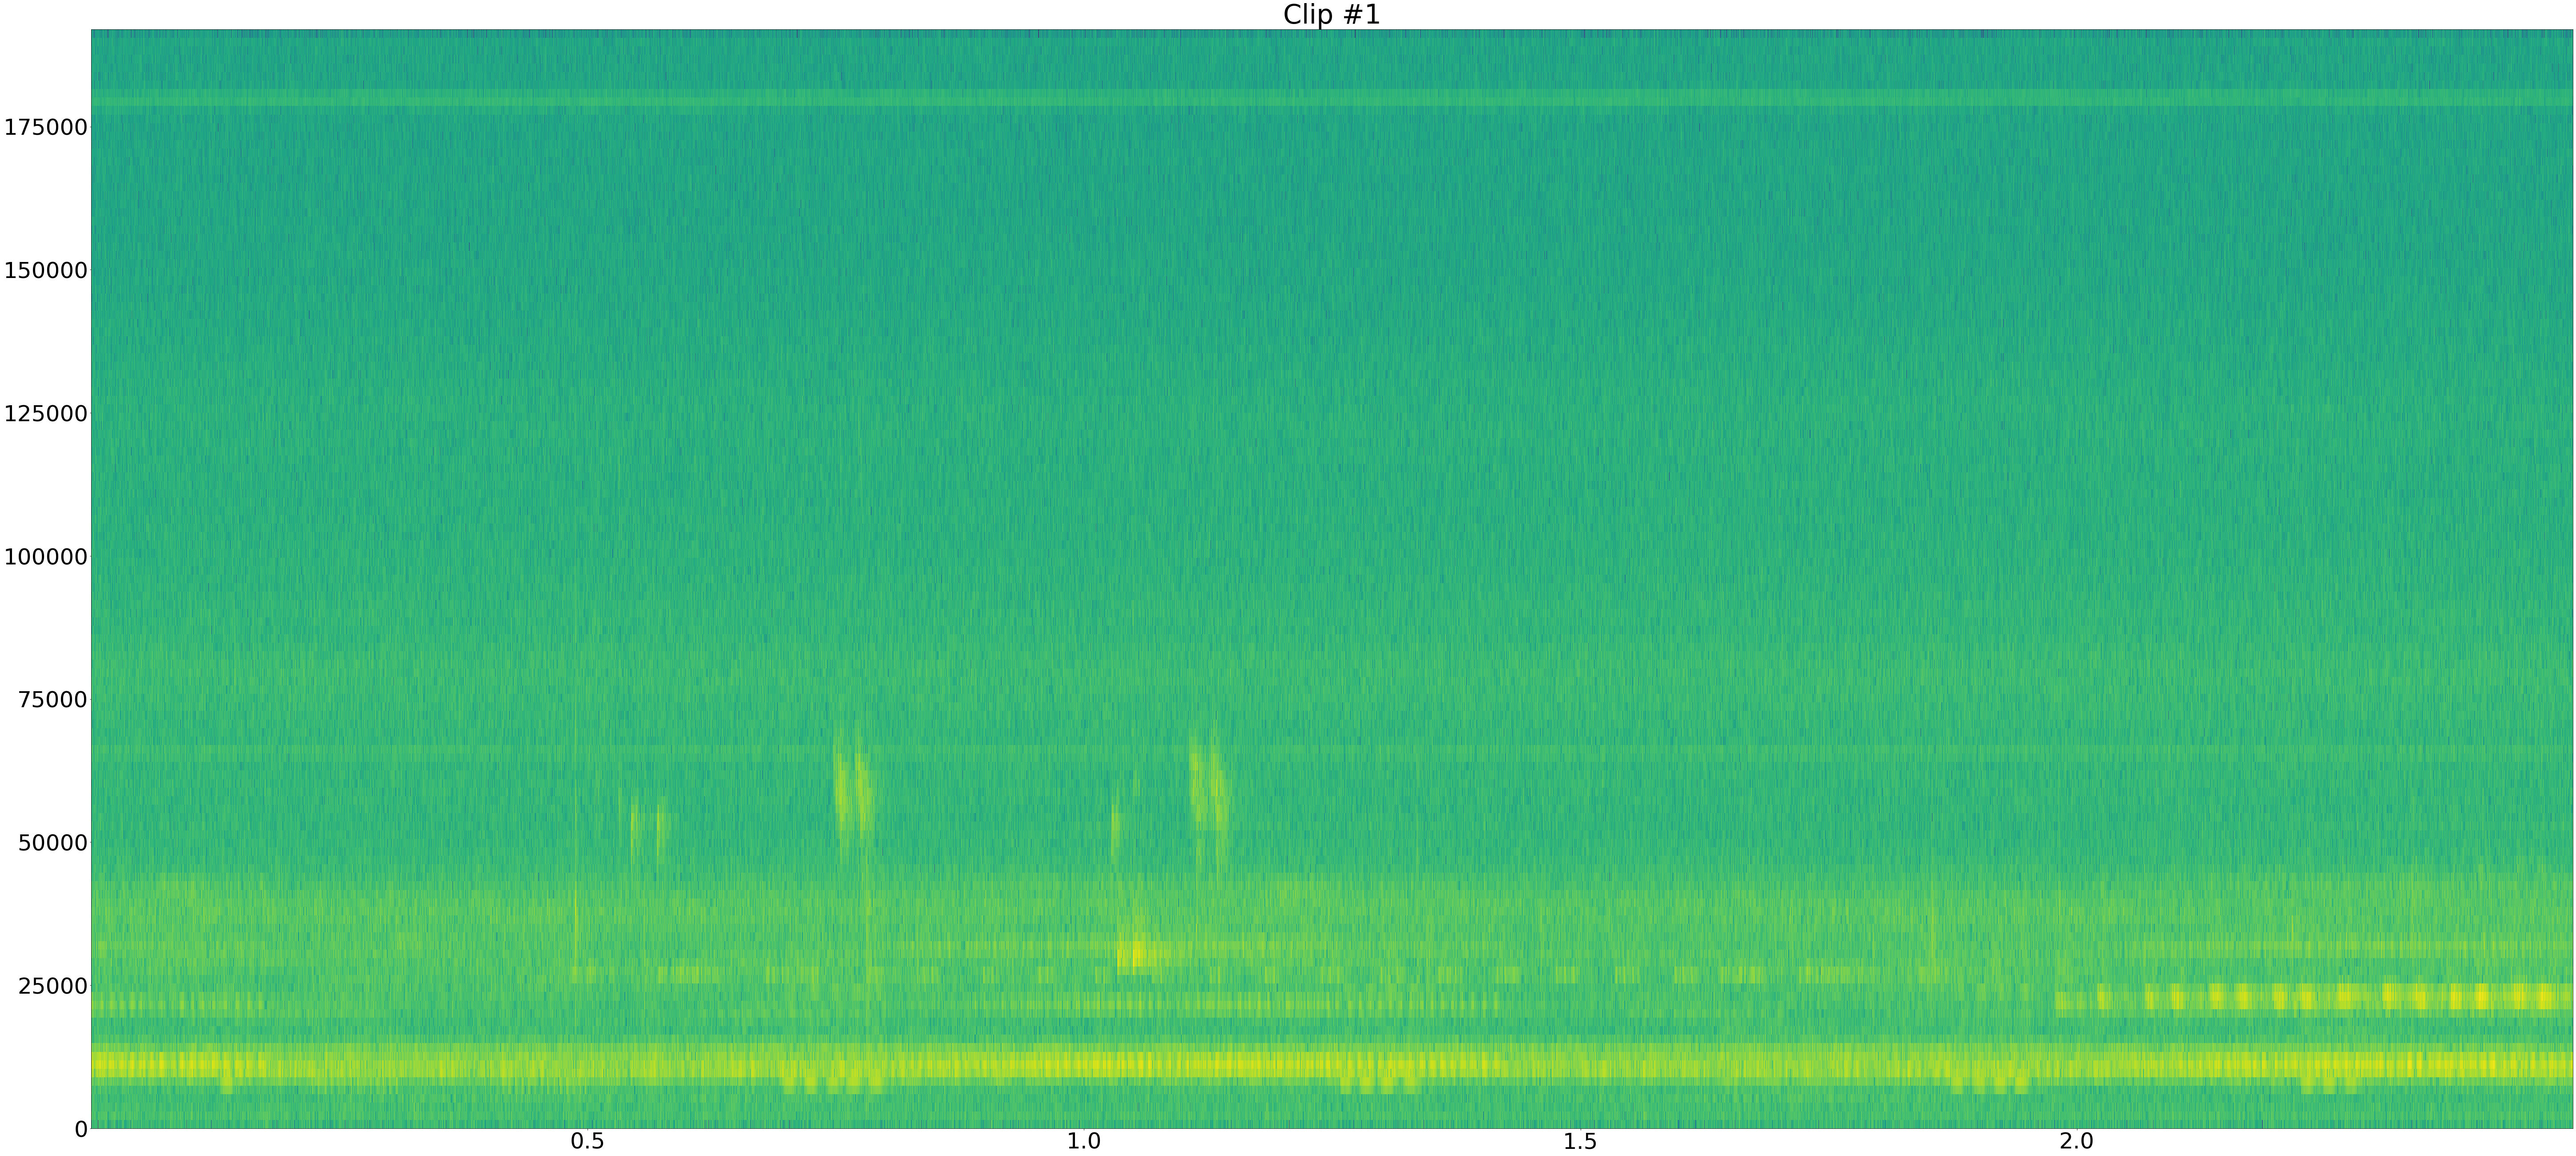

In [89]:
plot_spectrogram(samplerate, shorter_clips, 1)

# Feature Extraction

In [141]:
# TODO: Fix the warning "Increase NFFT to avoid."

def extract_features(shorter_clips, mfcc_only=False, mono=False):
    feat_clips = []

    print('Extracting features for each of the %d audio clips' % len(shorter_clips))
    for clip in shorter_clips:
        if mono == False:
            clip = clip.reshape((int(len(clip) / 2), 2))
            clip = clip[:, 0] + clip[:, 1] # Merging left and right channels

        mfcc_feat=None
        if mfcc_only:
            mfcc_feat = mfcc(clip, samplerate).flatten()

        else:
            mfcc_feat = ShortTermFeatures.feature_extraction(clip, samplerate, 0.050*samplerate, 0.025*samplerate)
            print('')
            print(mfcc_feat[1])

        # Append the features
        if mfcc_only:
            feat_clips.append(mfcc_feat)
        else:
            feat_clips.append(list_flatten(mfcc_feat[0]))

    print('done')
    return feat_clips
    
# Set mfcc_only to True to shorten runtime
mfcc_clips = extract_features(shorter_clips, mfcc_only=True, mono=False)
#all_feat_clips = extract_features(shorter_clips)

Extracting features for each of the 78 audio clips


done


# Clustering

In [135]:
dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

X = pos

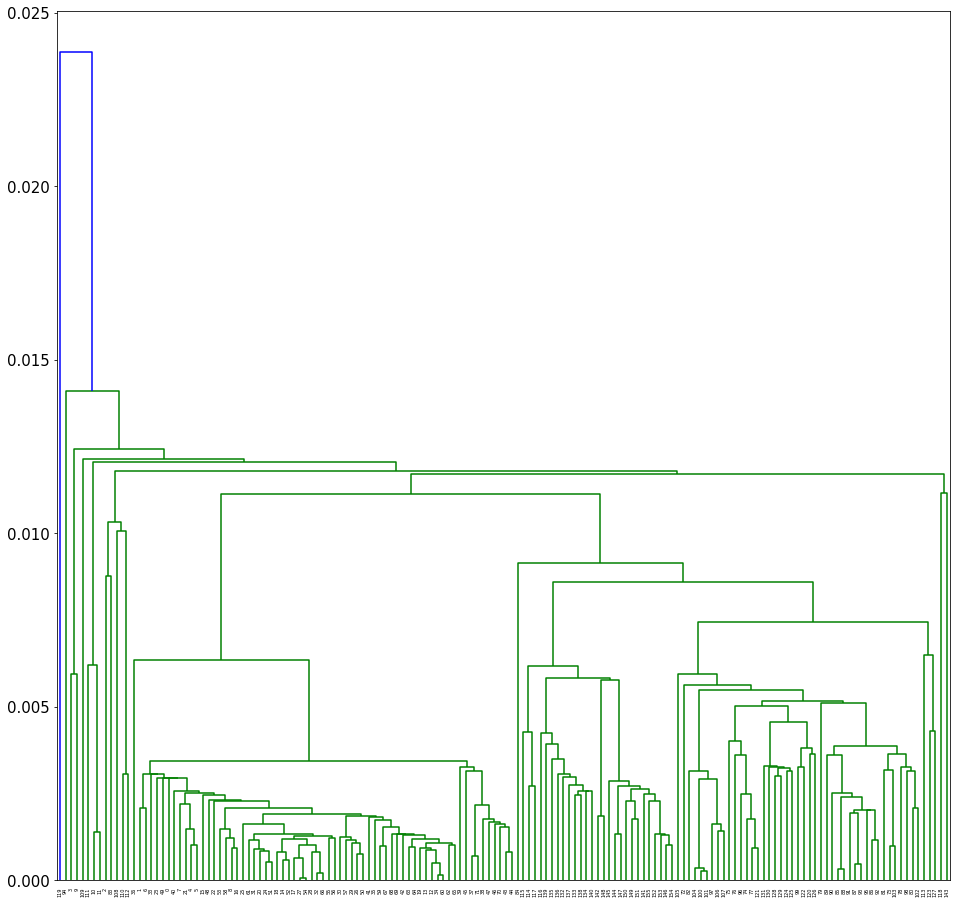

In [157]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(len(X))

plt.figure(figsize=(16, 16))
dendro = dendrogram(linked,
            #truncate_mode='level',
            #p=10,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [45]:
def find_optimal_clusters(data, min_k, max_k):
    iters = range(min_k, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Number of Clusters')
    plt.show()
    
# find_optimal_clusters(X, 90, 120)

In [158]:
# Choose number of clusters
n_clusters = 16

# Fit clustering model
clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(mfcc_clips)

In [159]:
def cluster_plot(pos, title='', without_labels=False, width=20, height=20, savepath=''):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    labels = range(len(shorter_clips))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        count = 0
        for i in range(len(cluster_df)):
            if count % 5 == 0:
                texts.append(ax.text(cluster_df.loc[i, 'x'], cluster_df.loc[i, 'y'], cluster_df.loc[i,'labels'], size=10)) 
            count += 1

        #adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

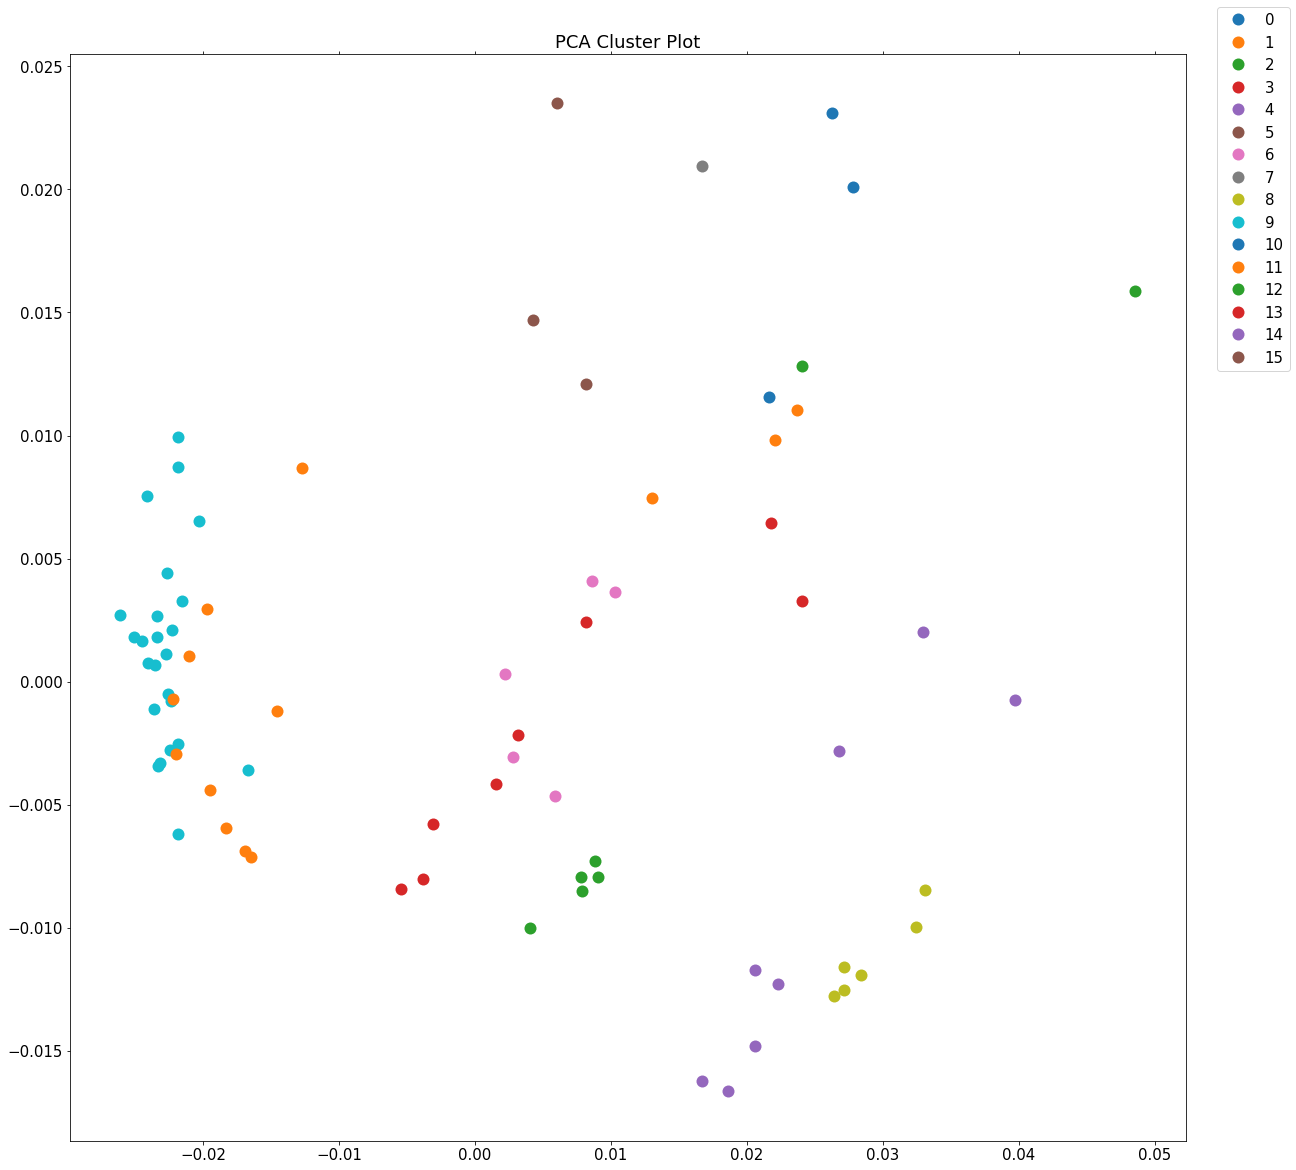

In [160]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'PCA Cluster Plot', without_labels=True)

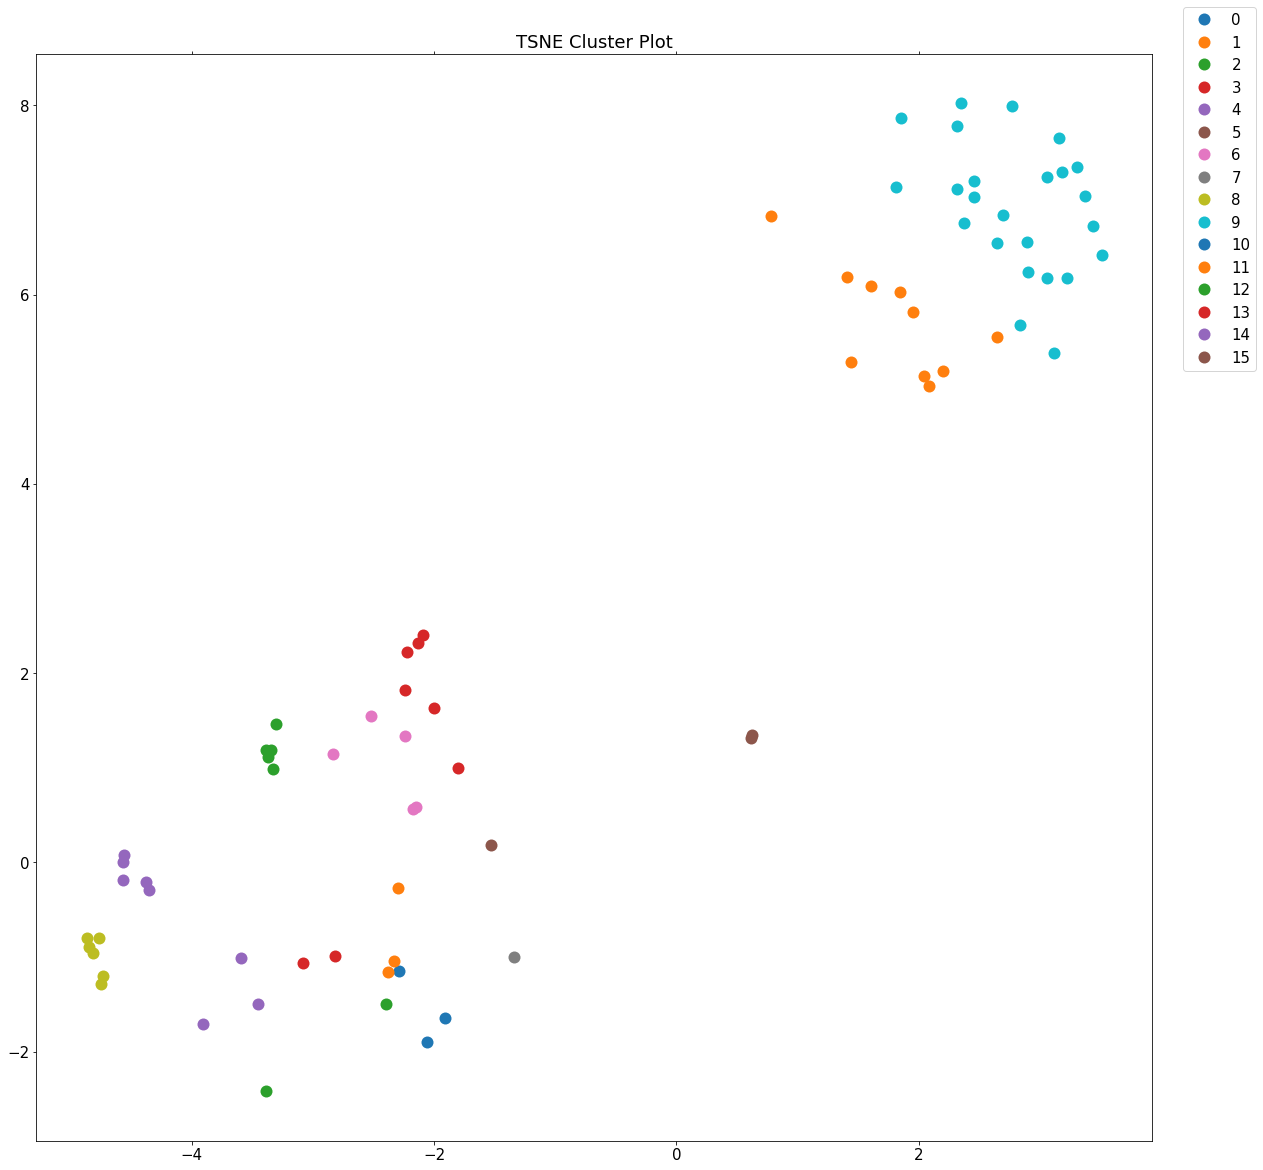

In [161]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(mfcc_clips)
mds = TSNE(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'TSNE Cluster Plot', without_labels=True)

# Cluster Interpretation

In [162]:
# Prints: (Cluster number, count of clips in cluster)
Counter(clusters).most_common()

[(9, 24),
 (11, 10),
 (2, 6),
 (13, 6),
 (8, 6),
 (6, 5),
 (14, 5),
 (4, 3),
 (1, 3),
 (5, 2),
 (0, 2),
 (3, 2),
 (15, 1),
 (10, 1),
 (7, 1),
 (12, 1)]

In [183]:
play_random_clip_in_cluster(6, clusters) # Play random clip in a cluster

Playing clip index 37 


In [318]:
# Can assign a label to each cluster here
cluster_names = ['quiet', 'loud', 'quiet', 'rain', 'birds', 'crickets']

Playing clip index 448 


In [178]:
# See clip indexes of all clips inside cluster
clip_indexes = get_clip_indexes(0, clusters)
print(clip_indexes)
# play_clip(36)

[36, 37, 40, 41]


In [185]:
def save_clusters_in_dir(dirname):
    for i in range(len(np.unique(clusters))):
        os.mkdir(dirname + 'cluster_%d' % i)
        for j in get_clip_indexes(i, clusters):
            save_clip(dirname + 'cluster_%d/%d' % (i, j), j) 
    
### Uncomment below to save all clusters in a folder of wav files
# save_clusters_in_dir('More_Clusters/')

# Visualization

In [320]:
num_clips = len(shorter_clips)
num_minutes = num_clips / 6
num_hours = num_minutes / 60

def clip_i_to_bin_i(clip_i):
    return int(clip_i / (num_clips/num_minutes))

def time_hist_for_cluster(cluster_i, clusters):
    hist_data = []
    for index in get_clip_indexes(cluster_i, clusters):
        index = clip_i_to_bin_i(index)
        hist_data.append(index)

    plt.ylim(0, (num_clips/num_minutes))
    plt.title('Cluster: %d (%s)' % (cluster_i, cluster_names[cluster_i]))
    plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes])
    plt.show()
    
def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret

def get_clusters_by_cluster_names(clusters, cluster_names):
    uniq_names = np.unique(cluster_names)
    print(uniq_names)
    new_clusters = [-1] * len(clusters)
    for uniq_name_i, uniq_name in enumerate(uniq_names):
        for name_i, name in enumerate(cluster_names):
            if name == uniq_name:
                # Assign name_i to each index in the cluster that has the same index
                for index in range(len(clusters)):
                    if clusters[index] == name_i:
                        new_clusters[index] = uniq_name_i
    return new_clusters

In [327]:
named_clusters = get_clusters_by_cluster_names(clusters, cluster_names)
Counter(named_clusters).most_common() 
cluster_names_to_plot = np.unique(cluster_names)

# Colors for visualization
jet = pl.get_cmap('jet', len(cluster_names_to_plot))
cluster_colors = {}
for i, name in enumerate(cluster_names_to_plot):
    cluster_colors[name] = jet(i)

['birds' 'crickets' 'loud' 'quiet' 'rain']


Note: These are not real labels for the clusters, this is just a demonstration of the code. The histogram visualization will be replaced with better visualizations for cluster/time data such as Rose Plots.

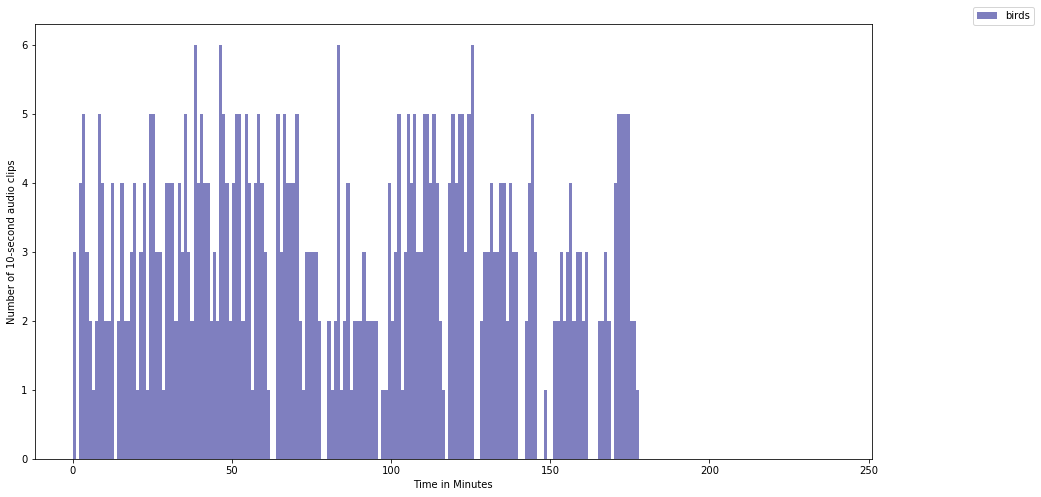

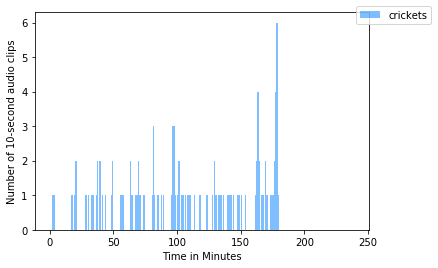

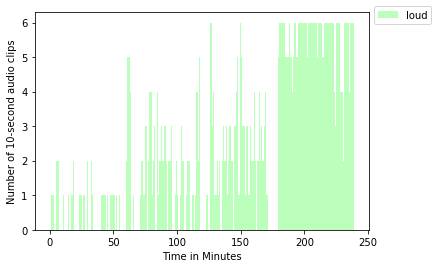

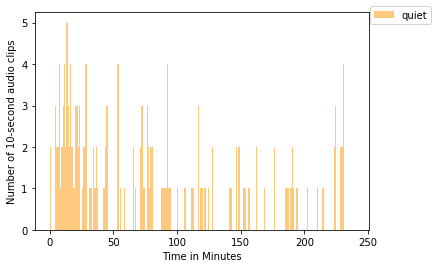

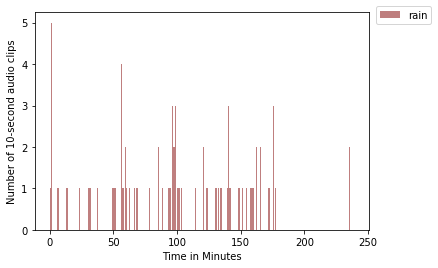

In [324]:
def plot_all_histograms(clusters, cluster_names):
    plt.figure(figsize=(15,8))

    for cluster_i in range(len(cluster_names)):
        hist_data = []
        for index in get_clip_indexes(cluster_i, clusters):
            index = clip_i_to_bin_i(index)
            hist_data.append(index)

        cluster_name = cluster_names[cluster_i]
        c = cluster_colors[cluster_name]
        plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes], alpha=0.5, color=c, label=cluster_name)

        plt.ylabel('Number of 10-second audio clips')
        plt.xlabel('Time in Minutes')
        plt.legend(bbox_to_anchor=(1.2, 1.05))
        plt.show()
    
clusters_to_plot = named_clusters
cluster_names_to_plot = np.unique(cluster_names)
plot_all_histograms(named_clusters, np.unique(cluster_names))